In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
#import data_layer_cross 
import statistics
import seaborn as sns
import tensorflow as tf

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class NeuralNet(nn.Module):
    """
    Neural network meta model
    """

    def __init__(self, input_dim, intermediate_dims=(20, 40, 20), dropout=0.9):

        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims
        # define the number of hidden layers
        self.hidden_num = len(intermediate_dims) + 1
        self.dropout = dropout
        self.output_dim = 1

        # define the first hidden layer
        exec("self.hidden_layer1 = nn.Linear({}, {})".format(input_dim, intermediate_dims[0]))
        # define the following hidden layers except for the last layer
        for i in range(len(intermediate_dims) - 1):
            exec(
                "self.hidden_layer{} = nn.Linear({}, {})".format(i + 2, intermediate_dims[i], intermediate_dims[i + 1]))
        # define the last hidden layer
        exec("self.hidden_layer_last = nn.Linear({}, 1)".format(intermediate_dims[-1]))

    def forward(self, x):
        # use loop to determine the next hidden layers
        for i in range(self.hidden_num - 1):
            x = eval("self.hidden_layer{}(x)".format(1 + i))
            x = F.relu(x)
            x = nn.functional.dropout(x, p=self.dropout)

        y = self.hidden_layer_last(x)
        #y = torch.tanh(y)


        return y

    def __repr__(self):
        return "NeuralNet(input_dim={}, output_dim={}, intermediate_dims={}, dropout={})".format(
            self.input_dim.__repr__(), self.output_dim.__repr__(),
            self.intermediate_dims.__repr__(), self.dropout.__repr__()
        )

In [3]:
#read input data 
datapath = "CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
data = np.load(datapath)
data, data['data'].shape, data['variable']

(NpzFile 'CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz' with keys: date, variable, wficn, data,
 (469, 3271, 61),
 array(['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment'], dtype='<U12'))

In [4]:
#calculate mean for the macro-vairbale
sentiment = data['data'][:,:,-1]
sentiment_list = sentiment.flatten()
sentiment_mean = np.mean(sentiment_list)
sentiment_mean

0.27884861407249484

In [5]:
'''for i in range (61):
    var = data['data'][:,:,i]
    var = replace_outliers(var, 100, -99, 0)
    max_value = np.max(var)
    min_value = np.min(var)
    print(max_value, min_value)'''

"for i in range (61):\n    var = data['data'][:,:,i]\n    var = replace_outliers(var, 100, -99, 0)\n    max_value = np.max(var)\n    min_value = np.min(var)\n    print(max_value, min_value)"

In [6]:
def replace_outliers(array, upper, lower, replace=0):
    # Create a mask for values that are less than lower or greater than upper
    #by default replace with 0 
    mask = (array < lower) | (array > upper)
    array[mask] = replace
    return array
def get_valid_label_mask(dataset,lower, upper):
    labels = dataset[:, :, 0]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows
def skip_labels(dataset, lower=-1, upper=1):
    #input should be the entire dataset 
    #skip the rows where there is no label 
    valid_rows = get_valid_label_mask(dataset, lower, upper)
    filtered_data = dataset[valid_rows]
    #print(filtered_data.shape)
    return filtered_data #this is of shape [time*funds, variables]
def sanitize_input(input_features, mean=0, mean_macro=sentiment_mean):
    #replace missing values in input with mean 
    #for macro variables, using mean_macro
    #expected input of shape [time*funds, variables] (2d)
    other_features = input_features[:,:-1]
    macro_features = input_features[:,-1:] #the last variable is the macro varibale
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    #print(other_features.shape, macro_features.shape)
    features_sanitized = np.concatenate((other_features, macro_features), axis=1)
    #print(features_sanitized.shape)
    return features_sanitized
def sanitize_input_3d(input_features, mean=0, mean_macro=sentiment_mean):
    #expected input: [time, funds, variables]
    other_features = input_features[:,:, :-1]
    macro_features = input_features[:,:, -1:]
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    features_sanitized = np.concatenate((other_features, macro_features), axis=2)
    return features_sanitized
def drop_input_based_on_r122(dataset):
    #drop row where r122 is 0 
    #input shape: [time*funds, variables]
    r122= dataset[:,10]
    mask = (r122 != 0)
    print(mask.shape)
    filtered_dataset = dataset[mask]
    return filtered_dataset
def get_valid_label_mask_month(labels,lower=-1, upper=1):
    #[funds,]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows

In [7]:
#pytorch dataset to help load input data
indexes= [0]+list(range(47,61))
class DS(Dataset):
    '''constrcuct datast with input data(the dataset) and index list'''
    def __init__(self, data, idx_list, subset=None, indexes= range(47,61)):
        #data --> the unprocessed input
        #index list: the selected indexes
        self.indexes = [0]+list(indexes)
        if subset:
            column_considered = [0] + [x + 1 for x in subset] #keep the first column(label)
            all_data = drop_input_based_on_r122(skip_labels(self.filter_data_by_indices(data['data'][:, :, column_considered], idx_list)))
            self.all_data=all_data[:,self.indexes]
        else:
            all_data = drop_input_based_on_r122(skip_labels(self.filter_data_by_indices(data['data'],idx_list)))
            self.all_data = all_data[:,self.indexes]
        labels = np.expand_dims(self.all_data[:, 0], axis=1)  #the first column contains the labels 
        print("labels shape",labels.shape)
        features = self.all_data[:, 1:] #the others are the input features
        features = sanitize_input(features)
        print("features shape",features.shape)
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
        
    def filter_data_by_indices(self, data, indices):
    #method to filter data with predefined indices
        return data[indices]
    
    def __len__(self):
        return self.features.shape[0] 

    def __getitem__(self, idx):
        #timestep = self.features.shape[0] - idx #during training, go from past time (larger index) to future time (smaller index)
        return self.features[idx], self.labels[idx] #get next month's label

In [8]:
#part3.1: sampling schemes 
def chronological_sampling_scheme(total_time_periods, split_ratio):
    """
    Simulates the chronological sampling scheme.
    total_time_periods(int):The total number of time periods(469)
    split_ratio (list or array of float): The split ratio [train, val, test]
    """
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #get indices 
    test_indices = np.arange(0, test_size)
    val_indices = np.arange(test_size, test_size + val_size)
    train_indices = np.arange(test_size + val_size, total_time_periods)
    return (test_indices, val_indices, train_indices)
def random_sampling_scheme(total_time_periods, split_ratio, random_seed=None):
    """The random sampling scheme"""
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #randomize all indices
    all_indices = np.arange(total_time_periods)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    return (train_indices, val_indices, test_indices)
def split_list_chronological(data, ratio):
    '''given data(list), return two sublists by ratio, chronologically'''
    split_index = int(len(data) * ratio)
    part1 = data[:split_index]
    part2 = data[split_index:]
    return part1, part2

In [9]:
def checkdb(dataset, dataloader):
    sample_features, sample_labels = dataset[0]
    print("Features shape:", sample_features.shape)
    print("Labels shape:", sample_labels.shape)
    data_iter = iter(dataloader)
    batch_features, batch_labels = next(data_iter) 
    print("loader Features shape:", batch_features.shape)
    print("loader Labels shape:", batch_labels.shape)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def loss_with_filter(preds, labels, lower=-1, upper = 1):
    #a custom loss function that filters placeholder values in the labels 
    #use MSE for the rest
    mask = (labels > lower) & (labels < upper)
    #print(preds.shape)
    #print(labels.shape)
    print('mask shape', mask.shape)
    filtered_preds = preds[mask]
    filtered_labels = labels[mask]
    print(filtered_preds.shape)
    print(filtered_labels.shape)
    #use mse
    #print(filtered_labels, filtered_preds)
    loss = nn.MSELoss()(filtered_preds, filtered_labels)
    return loss
def loss_with_filter_label_and_features(preds, labels, inputs, upper = 0.5, lower=-0.5):
    #filter both labels and input features
    #skip row if there is a missing value in features 
    global all_invalid_inputs
    #print(inputs.shape)
    mask_inputs = (inputs < upper).all(dim=-1, keepdim=True)
    mask_inputs = mask_inputs & ((inputs > lower).all(dim=-1, keepdim=True))
    mask = mask_inputs & (labels > lower) & (labels < upper)

    #total_funds = mask.shape[1]  
    #valid_rows_per_timestep = mask.sum(dim=1)  
    #all_invalid_inputs = total_funds - valid_rows_per_timestep 
    filtered_preds = preds[mask]
    filtered_labels = labels[mask]
    #print('v',filtered_preds, filtered_labels)
    if filtered_preds.numel() > 0:  
        loss = nn.MSELoss()(filtered_preds, filtered_labels)
    else:
        loss = torch.tensor(0.0, device=preds.device, requires_grad=True)
    #print('loss', loss)
    return loss
def inspect_parameter_scales(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter: {name}")
            print(f"  Mean: {param.data.mean().item()}")
            print(f"  Std: {param.data.std().item()}")
            print(f"  Min: {param.data.min().item()}")
            print(f"  Max: {param.data.max().item()}")
            print()

In [12]:
def train_model(model, num_epochs, dataloader_train, dataloader_val, device=device, criterion = nn.MSELoss(), learning_rate=0.01, early_stop=True, reg=1e-3):
    '''train model with specified datasets'''
    print('training start')
    print('----------------------')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_avg = [] #average loss over all epochs 
    validation_loss_avg =[] 
    train_loss_std = [] #std of losses over all epochs
    validation_loss_std = []
    lossV= float('inf')
    stop = False
    for epoch in range(num_epochs):
        train_loss = [] #inividual loss for a single epoch
        validation_loss = []
        model.train() 
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + reg * l2_reg
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            running_loss += loss.item()
        lossT = running_loss/len(dataloader_train)
        #train_loss_avg.append(lossT)
        #train_loss_std.append(statistics.stdev(train_loss))
        #validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                l2_reg = torch.tensor(0.)
                for param in model.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)
                loss = loss + reg * l2_reg
                validation_loss.append(loss.item())
                running_val_loss += loss.item()
        if (running_val_loss / len(dataloader_val)>=lossV):
            stop=True
        lossV = running_val_loss / len(dataloader_val)
        #validation_loss_avg.append(lossV)
        #validation_loss_std.append(statistics.stdev(validation_loss))
        print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
        if stop and early_stop:
            print('validation stopped converging')
            break 
    return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)

In [13]:
#3.3 Optimal Prediction
#now use the test set to yield estimations for each fund at each timestep
def predict(model, inputs):
    #predict at all timestep using model. inputs --> [time, funds, X]
    #return shape [time, funds, 1]
    input_features =torch.tensor(sanitize_input(inputs), dtype=torch.float32)#replace 
    model.eval()
    with torch.no_grad():
        outputs = model(input_features)
    #np.savetxt('sample.txt', outputs[:, :, -1], fmt='%s')
    #np.savetxt('inputsample.txt', input_features[0,:,:])
    return outputs

def reinitialize_with_glorot_uniform(model):
    """
    Reinitialize the parameters of the PyTorch model using TensorFlow's 
    default initializer (glorot_uniform, or Xavier uniform).
    
    Args:
        model (torch.nn.Module): The PyTorch model to reinitialize.
    """
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    model.apply(init_weights)

In [14]:
fold1, fold2, fold3 = chronological_sampling_scheme(469, [1,1,1]) #construct three folds with chronological sampling
all_folds = [fold1, fold2, fold3]  
all_folds
#now ->fold1->fold2->fold3->past

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156]),
 array([157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175

In [15]:
#for the three folds:
#first, train/val on the second and third folds and test on the first
all_predictions =[]
all_models = []
for i in range (3):
    print(f'iteration {i+1}')
    print('------------------------------------------')
    #construct corresponding datasets
    test_idx = all_folds[i]
    dataset_test = DS(data, test_idx)
    other_folds = [x for ind, x in enumerate(all_folds) if ind!=i]
    train_idx, val_idx = split_list_chronological(other_folds[0].tolist()+other_folds[1].tolist(), 0.75)
    dataset_train = DS(data, train_idx)
    dataset_val = DS(data, val_idx)
    #dataset_train = DS(data, other_folds[0])
    #dataset_val = DS(data, other_folds[1])
    batch_size_train = len(dataset_train)
    batch_size_val = len(dataset_val)
    train_loader = DataLoader(dataset_train, shuffle=True, batch_size= batch_size_train)
    valid_loader = DataLoader(dataset_val, shuffle=False, batch_size = batch_size_val)
    checkdb(dataset_train, train_loader)
    #define and train model 
    input_dim = 14
    hidden_dims = [64]  
    dropout = 0.05
    model = NeuralNet(input_dim=input_dim, intermediate_dims=hidden_dims, dropout=dropout) 
    reinitialize_with_glorot_uniform(model)
    train_model(model, 512, train_loader, valid_loader, early_stop=False)
    all_models.append(model)
    #predict with trained model 
    output = predict(model, sanitize_input_3d(data['data'][test_idx][:, :, indexes][:,:,1:])) #output shape [time, funds, 1]
    all_predictions.append(output)

iteration 1
------------------------------------------


(25985,)
labels shape (25908, 1)
features shape (25908, 14)
(273595,)
labels shape (273497, 1)
features shape (273497, 14)
(107577,)
labels shape (107540, 1)
features shape (107540, 14)
Features shape: torch.Size([14])
Labels shape: torch.Size([1])
loader Features shape: torch.Size([273497, 14])
loader Labels shape: torch.Size([273497, 1])
training start
----------------------
Epoch 1/512, Traning Loss: 0.04832912236452103, Validation loss: 0.022169316187500954
Epoch 2/512, Traning Loss: 0.027484113350510597, Validation loss: 0.018714021891355515
Epoch 3/512, Traning Loss: 0.022691935300827026, Validation loss: 0.01611335389316082
Epoch 4/512, Traning Loss: 0.018068190664052963, Validation loss: 0.013448063284158707
Epoch 5/512, Traning Loss: 0.015360535122454166, Validation loss: 0.012117319740355015
Epoch 6/512, Traning Loss: 0.01502189040184021, Validation loss: 0.011593898758292198
Epoch 7/512, Traning Loss: 0.014583643525838852, Validation loss: 0.011092215776443481
Epoch 8/512, T

In [16]:
sanitize_input_3d(data['data'][test_idx][:, :, indexes][:,:,1:]).shape

(156, 3271, 14)

In [17]:
def sort_fund(timestep_predictions):
  #input(fund_returns) of size (3271, 1) -->this is assumed to be the output of the (trained) model at one timestep
  #function to sort fund in deciles based on their predicted abnormal return for the next month
  fund_data = pd.DataFrame({'fund_id': np.arange(len(timestep_predictions)), 'predicted_abnormal_return': timestep_predictions})
  fund_data['rank'] = fund_data['predicted_abnormal_return'].rank(method='first', ascending=False)
  fund_data['decile'] = pd.qcut(fund_data['rank'], 10, labels=False) + 1
  return fund_data #dataframe with deciles ranks 

def select_decile(fund_data, decile):
    #get indices of all funds within the same decile 
    if decile < 1 or decile > 10:
        raise ValueError("Decile should be between 1 and 10.")
    selected_funds = fund_data[fund_data['decile'] == decile]['fund_id'].values
    return selected_funds

def equal_weight(month_returns):
    #given abnormal returns of the month, return the evenly weighted return 
    #print(torch.mean(month_returns))
    return torch.mean(month_returns)
      

In [18]:
def plot_returns(abnormal_returns_list, labels, cumulative=False):
    #plot abnormal returns
    #abnormal returns is a list of dictionaries {timestep-->abnormal return}
    #labels is a list of labels (corresponding to each decile)
    #cumulative --> whether to use cumulative return 
    if len(abnormal_returns_list) != len(labels):
        raise ValueError("returns list and labels should match in dimension")
    for i in range (len(abnormal_returns_list)):
        #if i==0:
        #    continue
        timesteps = range(len(abnormal_returns_list[i])+1)
        abnormal_returns = abnormal_returns_list[i]
        abnormal_returns.insert(0, 0) #start with 0 
        if cumulative:
            cumulative_returns = []
            cumulative_log_return_sum  = 0
            #print('abnormal_returns', abnormal_returns)
            for ar in abnormal_returns:
                if torch.is_tensor(ar) and torch.isnan(ar):
                    ar =  0
                cumulative_log_return_sum += (np.log(ar + 1))
                # Calculate the cumulative abnormal return at this timestep
                #print('cumul',cumulative_log_return_sum)
                cumulative_returns.append(np.exp(cumulative_log_return_sum)-1)
                #print(ar)
                #print(cumulative_log_return_sum)
                #print(np.exp(cumulative_log_return_sum)-1)
                #print(cumulative_returns)
                #print('cm', (np.exp(cumulative_log_return_sum))-1)
                #print(cumulative_returns)
            #print('abnormal returns', abnormal_returns)
            #print('cumulative_returns', cumulative_returns)
            plt.plot(timesteps, cumulative_returns, label=labels[i])
        else:
            plt.plot(timesteps, abnormal_returns)
        #print(len(timesteps), len(cumulative_returns))
    plt.xlabel('Time')
    plt.ylabel('Cumulative Abnormal Return')
    plt.title('Cumulative Abnormal Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_returns(all_timestep_return, labels, cumulative=True)

In [19]:
#plot_returns(all_timestep_return, labels, cumulative=True)
'''
abnormal_returns = np.loadtxt('normal.txt')
logsum=0
logsum_list = []
cummulative_list =[]
for i in range (len(abnormal_returns)):
    curr = abnormal_returns[i]
    logsum += (np.log(abnormal_returns[i] + 1))
    logsum_list.append(logsum)
    cummulative = np.exp(logsum)-1
    cummulative_list.append(cummulative)
print(logsum_list)
print(cummulative_list)'''

"\nabnormal_returns = np.loadtxt('normal.txt')\nlogsum=0\nlogsum_list = []\ncummulative_list =[]\nfor i in range (len(abnormal_returns)):\n    curr = abnormal_returns[i]\n    logsum += (np.log(abnormal_returns[i] + 1))\n    logsum_list.append(logsum)\n    cummulative = np.exp(logsum)-1\n    cummulative_list.append(cummulative)\nprint(logsum_list)\nprint(cummulative_list)"

In [20]:
#now concatenate all predictions together
outputs = torch.cat(all_predictions, dim=0)
outputs.shape

torch.Size([469, 3271, 1])

In [21]:
#for each timestep: 1. make prediction based on input, 2. rank funds to deciles 3. graph all cumulative return (from label)
#cumulative graph for fold1
'''
output1= all_predictions[2]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold1,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output1, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput1= all_predictions[2]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold1,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output1, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [22]:
#cumulative graph for fold2

'''
output2 = all_predictions[1]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold2,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output2, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput2 = all_predictions[1]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold2,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output2, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [23]:
#cumulative graph for fold3
'''
output3 = all_predictions[0]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold3,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output3, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput3 = all_predictions[0]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold3,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output3, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [24]:
invalid_funds_list = []
invalid_time_list = []

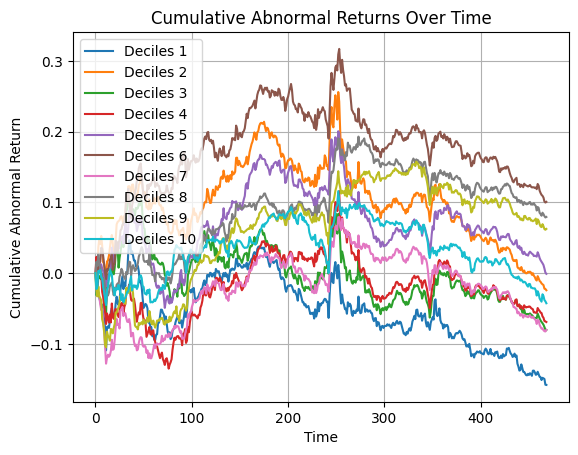

In [25]:
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid)
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        if return_month.isnan():
            print("time", i)
            invalid_time_list.append(i)
            invalid_funds_list.append(decile_ind)
        exec(f'timestep_return_{j}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [26]:
for i in range (len(invalid_funds_list)):
    invalid_time = invalid_time_list[i]
    invalid_funds = invalid_funds_list[i]
    curr = torch.tensor(data['data'][invalid_time, invalid_funds, 0])
    if not torch.all(curr==-9.998999999999999488e+01):
        print(i)

In [27]:
#graph the actual cumulative return 
#take the actual rank from the labels and graph 
'''
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (0, 469):
    #sort funds based on model prediction
    time = i #the current timestep
    fund_data = sort_fund(all_labels, timestep=time)
    #fund_data.to_csv('funddata.csv')
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (0, 469):\n    #sort funds based on model prediction\n    time = i #the current timestep\n    fund_data = sort_fund(all_labels, timestep=time)\n    #fund_data.to_csv(\'funddata.csv\')\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [28]:
#torch.save(model, 'trainedModels/curr')

(405948,)


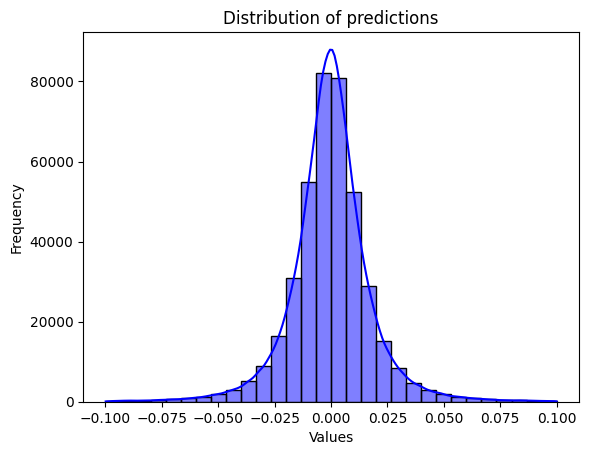

mean: -0.0003016347279621623
median: -0.00027827569528846366
std: 0.017939859528875442


In [29]:
#histogram of actual label distribution 
mask = (all_labels<0.1) & (all_labels>-0.1)
valid_labels = all_labels[mask]
print(valid_labels.shape)
valid_labels=valid_labels.flatten()
sns.histplot(valid_labels, bins=30, kde=True, color='blue')
plt.title('Distribution of predictions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()
print("mean:", statistics.mean(valid_labels))
print("median:", statistics.median(valid_labels))
print("std:", statistics.stdev(valid_labels))

In [30]:
all_labels_flattened = all_labels.flatten()
print(len(all_labels_flattened))
missing = 0
for label in all_labels_flattened:
    if label== -99.99:
        missing += 1
print(missing)
print(len(all_labels_flattened)-missing)

1534099
1126941
407158


In [31]:
mask = (all_labels != -99.99) 
valid_labels = all_labels[mask]
valid_labels=valid_labels.flatten()
print(len(valid_labels))
print(np.mean(valid_labels))
print(np.median(valid_labels))
print(np.std(valid_labels))
#label is not percentils

407158
-0.00028213726051122355
-0.0002777386798632417
0.01999964362140899


In [32]:
def r2_loss(output, target, target_mean='infer'):
    if target_mean == "infer":
        target_mean = np.mean(target)
    ss_tot = np.sum((target - target_mean) ** 2)
    ss_res = np.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [33]:
#calculate R2 loss
outputs = torch.cat(all_predictions, dim=0).numpy()
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2)
#mask off all missing values 
mask = (all_labels > -1)&(all_labels<1)
print(mask.shape)
outputs = outputs[mask]
all_labels = all_labels[mask]
print(outputs.shape, all_labels.shape)
outputs_flattend= outputs.flatten()
all_labels_flattened = all_labels.flatten()
R2 = r2_loss(outputs_flattend, all_labels_flattened, 0)
R2

(469, 3271, 1)
(407157,) (407157,)


-0.00014079620411044935

In [34]:
#torch.save(model, 'trainedModels/curr')

In [35]:
checkpoint_list = ['Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/Train_fold_8/fullnew46591640.950.00.0010.01naturalTestorder0']
for checkpoint in checkpoint_list:
    ckpt = tf.train.load_checkpoint(checkpoint)
    variable_names = ckpt.get_variable_to_shape_map()
    for var_name in variable_names:
        print(f"Variable: {var_name}, Shape: {variable_names[var_name]}")

Variable: global_step, Shape: []
Variable: OptimizeLoss/learning_rate, Shape: []
Variable: OptimizeLoss/beta2_power, Shape: []
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/kernel/Adam_1, Shape: [64, 1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/bias/Adam, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/bias/Adam_1, Shape: [64]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/bias/Adam, Shape: [64]
Variable: Model_Layer/NN_Layer/last_dense_layer/dense/kernel, Shape: [64, 1]
Variable: Model_Layer/NN_Layer/last_dense_layer/dense/bias, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/kernel/Adam, Shape: [64, 1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/bias/Adam_1, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/kernel/Adam, Shape: [14, 64]
Variable: Model_Layer/NN_Layer/dense_layer_0/dense/kernel, Shape: [14, 64]
Variable:

In [36]:
class SimpleDenseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleDenseModel, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        return x
def load_tf_weights_to_pytorch(checkpoint_path, input_size, hidden_size, output_size):
    # Use compatibility mode to access TensorFlow 1.x functionality
    tf.compat.v1.disable_eager_execution()

    # Create a NewCheckpointReader to read the TensorFlow checkpoint
    reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)

    # Extract weights and biases from the checkpoint
    dense1_weights = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/kernel')
    dense1_bias = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/bias')
    dense2_weights = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/kernel')
    dense2_bias = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/bias')

    # Construct the PyTorch model with similar architecture
    model = SimpleDenseModel(input_size, hidden_size, output_size)
    
    # Load the weights and biases into the PyTorch model
    with torch.no_grad():
        model.dense1.weight = nn.Parameter(torch.tensor(dense1_weights.T))
        model.dense1.bias = nn.Parameter(torch.tensor(dense1_bias))
        model.dense2.weight = nn.Parameter(torch.tensor(dense2_weights.T))
        model.dense2.bias = nn.Parameter(torch.tensor(dense2_bias))

    return model

In [37]:
train_fold_list = []
root ='Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/' 
for i in range(1, 9):
    one_train_fold = []
    for j in range(3):
        path = root + f'Train_fold_{i}/fullnew46591640.950.00.0010.01naturalTestorder{j}/model-best'
        one_train_fold.append(path)
    train_fold_list.append(one_train_fold)

In [38]:
all_outputs = []
indexes = range (47, 61)
for checkpoint_list in train_fold_list:
    model_list = []
    input_size = 14
    hidden_size = 64
    output_size = 1
    for checkpoint in checkpoint_list:
        pytorch_model = load_tf_weights_to_pytorch(checkpoint, input_size, hidden_size, output_size)
        model_list.append(pytorch_model)
    inputs_test = torch.tensor(sanitize_input_3d(data['data'][:,:,indexes]), dtype=torch.float32)
    output_list = []
    for i in range (3):
        inputs_test = torch.tensor(sanitize_input_3d(data['data'][all_folds[i]][:,:,indexes]), dtype=torch.float32)
        curr_model = model_list[i]
        output_list.append(curr_model(inputs_test))
    outputs = torch.cat(output_list, dim=0)
    all_outputs.append(outputs)

In [39]:
def get_mean_elementwise(tensor_list):
    stacked_tensors = torch.stack(tensor_list)
    mean_tensor = torch.mean(stacked_tensors, dim=0)
    return mean_tensor

In [40]:
outputs = get_mean_elementwise(all_outputs)
output.shape

torch.Size([156, 3271, 1])

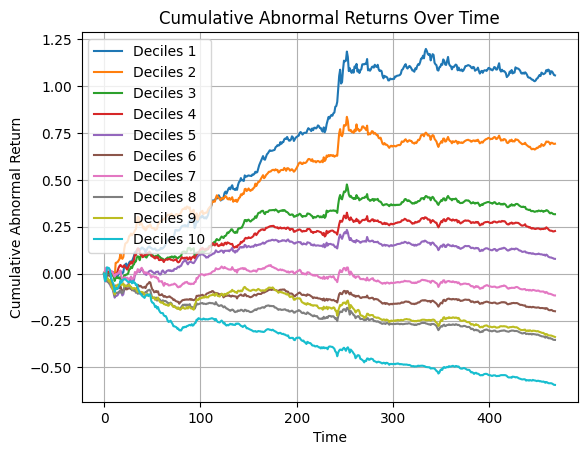

In [41]:
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid.detach().numpy())
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        if return_month.isnan():
            print("time", i)
            invalid_time_list.append(i)
            invalid_funds_list.append(decile_ind)
        exec(f'timestep_return_{j}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [42]:
sampling_folds = np.load('Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/sampling_folds/chronological_order_folds.npy', allow_pickle=True)
len(sampling_folds),sampling_folds[0]

(3,
 array([array([156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
               169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
               182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
               195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
               208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
               221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
               234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
               247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
               260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
               273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
               286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
               299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
               312, 313, 314, 315, 3

In [43]:
my_model = all_models[0]
target_model = model_list[0]
inspect_parameter_scales(my_model)

Parameter: hidden_layer1.weight
  Mean: 6.138695880508749e-06
  Std: 0.00024519351427443326
  Min: -0.002978285774588585
  Max: 0.003298065857961774

Parameter: hidden_layer1.bias
  Mean: 1.6273706933134235e-05
  Std: 0.00012970562966074795
  Min: -2.613286596897524e-05
  Max: 0.0010370741365477443

Parameter: hidden_layer_last.weight
  Mean: -9.124640200752765e-06
  Std: 6.562348426086828e-05
  Min: -0.0005169692449271679
  Max: 1.2545657227747142e-05

Parameter: hidden_layer_last.bias
  Mean: -4.462645301828161e-05
  Std: nan
  Min: -4.462645301828161e-05
  Max: -4.462645301828161e-05



/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_42836/3423724609.py:42: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  print(f"  Std: {param.data.std().item()}")


In [44]:
inspect_parameter_scales(target_model)

Parameter: dense1.weight
  Mean: 5.3109830332687125e-05
  Std: 0.0003968699893448502
  Min: -0.001423225156031549
  Max: 0.006353115662932396

Parameter: dense1.bias
  Mean: -0.00025214790366590023
  Std: 0.0009016735712066293
  Min: -0.0029077925719320774
  Max: 0.0016809843946248293

Parameter: dense2.weight
  Mean: 0.00016703216533642262
  Std: 0.002081038663163781
  Min: -0.006569933146238327
  Max: 0.0061277905479073524

Parameter: dense2.bias
  Mean: -0.00023053574841469526
  Std: nan
  Min: -0.00023053574841469526
  Max: -0.00023053574841469526



/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_42836/3423724609.py:42: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  print(f"  Std: {param.data.std().item()}")
